In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Uniaxial_PI.csv')
fatigue_df

,Heat,Stress (Mpa),Number of Cycles,Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,...,Mn,P,S,Ni,Cr,Cu,Method,Test Type,Dataset,PI Fatigue Life
0,1,400,25400,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,6.142922e+02
1,1,380,38800,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,1.264736e+04
2,1,380,48100,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,1.264736e+04
3,1,370,77200,600,825,0.05,0.03,0.0,20,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,6.095369e+04
4,1,370,152000,600,825,0.05,0.03,0.0,120,26,...,0.77,0.021,0.022,0.01,0.01,0.02,uniaxial,reversed,2,6.095369e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,24,400,63000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,4.216358e+04
202,24,380,165000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,2.812306e+05
203,24,380,300000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,2.812306e+05
204,24,360,1030000,600,660,0.06,0.00,0.0,120,19,...,0.67,0.019,0.026,0.04,0.13,0.11,uniaxial,repeated,4,2.078500e+06


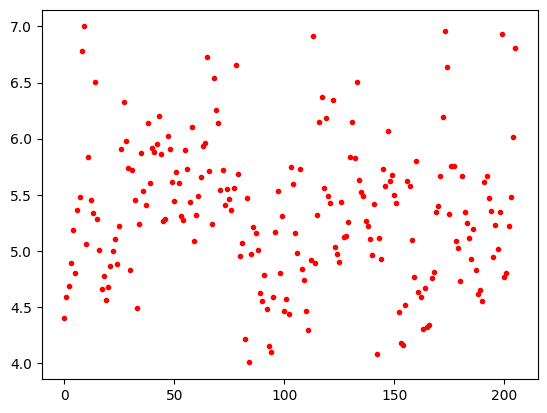

In [ ]:
# Scatter Plot
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles','Method','Dataset'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# One-hot encoding the 'Test Type' column
features = pd.get_dummies(features, columns=['Test Type'], prefix='Test Type')

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu,PI Fatigue Life,Test Type_repeated,Test Type_reversed
0,490,600,1740,0.07,0.00,0.0,20,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,7.020612e+03,False,True
1,520,600,1750,0.07,0.00,0.0,20,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,7.256881e+03,False,True
2,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.254765e+04,False,True
3,440,600,1270,0.12,0.01,0.0,20,24,68,0.45,0.26,0.76,0.027,0.019,0.01,0.11,0.02,1.254765e+04,False,True
4,520,600,1270,0.08,0.01,0.0,20,22,60,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01,9.634130e+03,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,340,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,1.722116e+07,True,False
202,350,600,1740,0.07,0.00,0.0,120,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.02,7.016572e+06,True,False
203,360,600,660,0.06,0.00,0.0,120,19,58,0.56,0.26,0.67,0.019,0.026,0.04,0.13,0.11,2.078500e+06,True,False
204,365,600,1750,0.07,0.00,0.0,120,22,60,0.55,0.23,0.76,0.018,0.012,0.01,0.09,0.01,7.211075e+06,True,False


In [ ]:
# Convert the features into floats
features = features.astype('float64')

In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
Pearson CC: 0.6624000068162033
R2 score: 0.40287241014411024
RMSE: 0.4646416965779979
MAE: 0.34672117395936364
Coverage: 85.71428571428572
Upper coverage: 95.23809523809524
Lower coverage: 90.47619047619048
Pearson R2 median: 0.6624000068162033
R2 median: 0.40287241014411024
RMSE median: 0.4646416965779979
Average Interval Width: 1.3912590504997178
Median Interval Width: 1.2989603512350385
Composite Metric: 0.8353187524530805


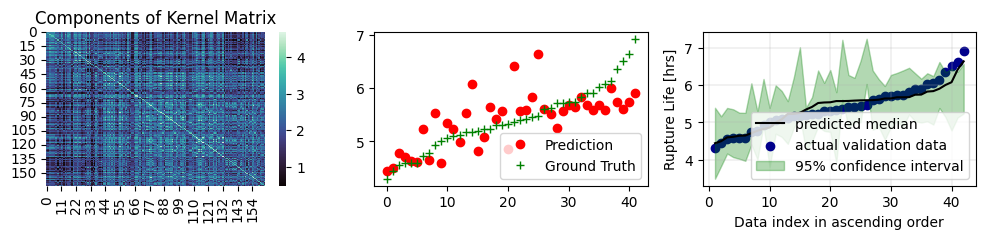

********************
Run # 1 Fold # 2
Pearson CC: 0.27695200012987636
R2 score: -6.711079311972729
RMSE: 1.9008038700414047
MAE: 0.5391980604945465
Coverage: 92.6829268292683
Upper coverage: 97.5609756097561
Lower coverage: 95.1219512195122
Pearson R2 median: 0.27695200012987636
R2 median: -6.711079311972729
RMSE median: 1.9008038700414047
Average Interval Width: 1.7280266067990278
Median Interval Width: 1.3277654787099498
Composite Metric: 0.8834082141240869


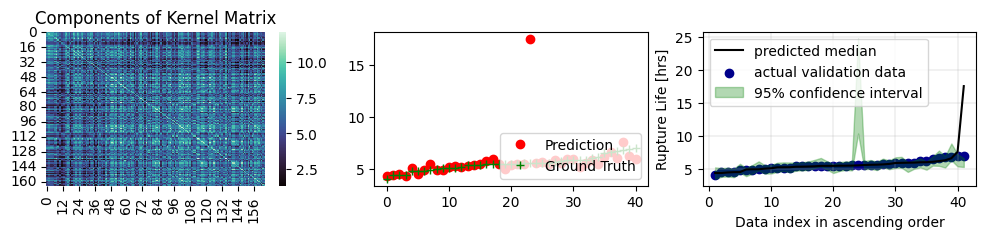

********************
Run # 1 Fold # 3


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.8601731715658177
R2 score: 0.6762686409072505
RMSE: 0.315035182211384
MAE: 0.2255050044027663
Coverage: 95.1219512195122
Upper coverage: 95.1219512195122
Lower coverage: 100.0
Pearson R2 median: 0.8601731715658177
R2 median: 0.6762686409072505
RMSE median: 0.315035182211384
Average Interval Width: 1.5025329387969135
Median Interval Width: 1.4740784588782478
Composite Metric: 0.8830121196087138


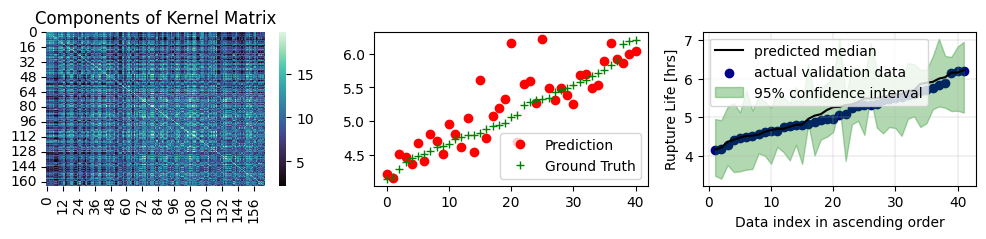

********************
Run # 1 Fold # 4


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.802149418197491
R2 score: 0.6422896187151741
RMSE: 0.3858445479907245
MAE: 0.2735620856945445
Coverage: 87.8048780487805
Upper coverage: 95.1219512195122
Lower coverage: 92.6829268292683
Pearson R2 median: 0.802149418197491
R2 median: 0.6422896187151741
RMSE median: 0.3858445479907245
Average Interval Width: 1.439337669063376
Median Interval Width: 1.394707774773023
Composite Metric: 0.8377856040649037


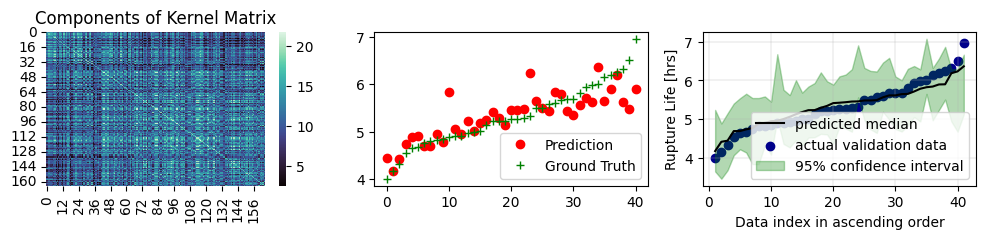

********************
Run # 1 Fold # 5


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.7895526207248913
R2 score: 0.6037292026168265
RMSE: 0.3387015977482288
MAE: 0.2446749321966616
Coverage: 95.1219512195122
Upper coverage: 97.5609756097561
Lower coverage: 97.5609756097561
Pearson R2 median: 0.7895526207248913
R2 median: 0.6037292026168265
RMSE median: 0.3387015977482288
Average Interval Width: 1.4567025490181018
Median Interval Width: 1.4377647604470774
Composite Metric: 0.8872956520134518


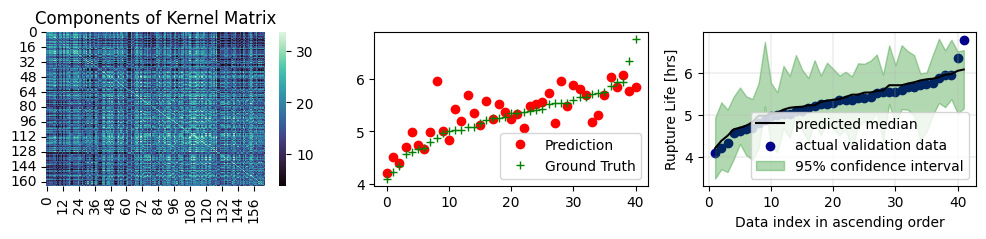

********************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1

nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)

            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)
            upper_coverage[j, i] = coverage(y_test, df_test_low, np.inf)
            lower_coverage[j, i] = coverage(y_test, -np.inf, df_test_high)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')
            print(f'Upper coverage: {upper_coverage[j, i]}')
            print(f'Lower coverage: {lower_coverage[j, i]}')

            print(f"Pearson R2 median: {pearsonr(y_test, df_test_median)[0]}")
            print(f"R2 median: {r2_score(y_test, df_test_median)}")
            print(f"RMSE median: {np.sqrt(mean_squared_error(y_test, df_test_median))}")

            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.
            mean_interval_width[j, i] = np.mean(df_test_high - df_test_low)
            print(f'Average Interval Width: {mean_interval_width[j, i]}')
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            plt.figure(figsize=(12,2))
            plt.subplot(131)
            K = model.kernel_(model.X_train_)
            K[np.diag_indices_from(K)] += model.alpha
            sns.heatmap(K, cmap='mako')
            plt.title('Components of Kernel Matrix')
            plt.subplot(132)
            plt.plot(y_pred_test, 'ro', label='Prediction')
            plt.plot(np.array(y_test), 'g+', label='Ground Truth')
            plt.legend(loc=4)
            plt.subplot(133)
            plt.plot(np.arange(1, len(y_test)+1), sorted(df_test_median),
                     label='predicted median', color='k')
            plt.scatter(np.arange(1, len(y_test)+1), y_test,
                         marker='o', color='darkblue', label='actual validation data')
            plt.fill_between(np.arange(1, len(y_test)+1), df_test_low,
                             df_test_high, alpha=0.3,
                           color='green', label='95% confidence interval')
            plt.grid(True, which='major', linestyle='-', linewidth='0.25')#, color='gray')
            plt.ylabel('Rupture Life [hrs]')
            plt.xlabel('Data index in ascending order')
            plt.ticklabel_format(style='sci', scilimits=(-3,4), axis='y')
            plt.legend()
            plt.show()

            print(20*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.662400,0.402872,0.464642,0.346721,85.714286
1,0.276952,-6.711079,1.900804,0.539198,92.682927
2,0.860173,0.676269,0.315035,0.225505,95.121951
3,0.802149,0.642290,0.385845,0.273562,87.804878
4,0.789553,0.603729,0.338702,0.244675,95.121951


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.678245,0.210773,-0.877184,2.918493,0.681005,0.612037,0.325932,0.11432,91.289199,3.861155


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Upper Coverage': upper_coverage.flatten(), 'Lower Coverage': lower_coverage.flatten(),
                    'Mean Interval Width': mean_interval_width.flatten(), 'Median Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Upper Coverage,Lower Coverage,Mean Interval Width,Median Interval Width,Composite Metric
0,85.714286,95.238095,90.476190,1.391259,1.298960,0.835319
1,92.682927,97.560976,95.121951,1.728027,1.327765,0.883408
2,95.121951,95.121951,100.000000,1.502533,1.474078,0.883012
3,87.804878,95.121951,92.682927,1.439338,1.394708,0.837786
4,95.121951,97.560976,97.560976,1.456703,1.437765,0.887296


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Upper Coverage Mean,Upper Coverage Std,Lower Coverage Mean,Lower Coverage Std,Mean Interval Width Mean,Mean Interval Width Std,Median Interval Width Mean,Median Interval Width Std,Composite Metric Mean,Composite Metric Std
0,91.289199,3.861155,96.12079,1.176671,95.168409,3.384238,1.503572,0.117744,1.386655,0.065541,0.865364,0.023585
